In [241]:
# Import necessary libraries
from sklearn.linear_model import SGDRegressor  # Stochastic Gradient Descent Regressor
from sklearn.metrics import mean_absolute_error, mean_squared_error  # Evaluation metrics
import pandas as pd  # Data manipulation
import matplotlib.pyplot as plt  # Visualization
import seaborn as sns  # Advanced visualizations
from sklearn.model_selection import train_test_split  # Splitting data into train and test sets



df = pd.read_csv("/workspaces/bakery_sales_prediction/0_DataPreparation/00_data/data_long.csv")
#print(data.head())
#data brot:
#data brot:
data = df[df["Warengruppe_2"] == 1].copy()
data_wetter = pd.read_csv("/workspaces/bakery_sales_prediction/2_BaselineModel/02_Franz/weather_data_with_flags.csv")

#Werktag
data['Werktag'] = (
    data[['Montag', 'Dienstag', 'Mittwoch', 'Donnerstag', 'Freitag']].sum(axis=1) > 0
) & (data['Feiertag'] == 0)
# In 0/1 umwandeln
data['Werktag'] = data['Werktag'].astype(int)

# Sicherstellen, dass "Datum" im Datumsformat ist
data['Datum'] = pd.to_datetime(data['Datum'])
# Jahreszeiten zuweisen
data['Frühling'] = data['Datum'].dt.month.isin([3, 4, 5]).astype(int)
data['Sommer'] = data['Datum'].dt.month.isin([6, 7, 8]).astype(int)
data['Herbst'] = data['Datum'].dt.month.isin([9, 10, 11]).astype(int)
data['Winter'] = data['Datum'].dt.month.isin([12, 1, 2]).astype(int)

#Number of Ships skalieren
# Min-Max-Skalierung manuell berechnen
data['Number_of_ships_scaled'] = (
    data['Number_of_ships'] - data['Number_of_ships'].min()
) / (data['Number_of_ships'].max() - data['Number_of_ships'].min())

#neue Wetterkategorien
data_wetter["date"] = pd.to_datetime(data_wetter["date"])
data = data.merge(data_wetter, how="left", left_on="Datum", right_on="date").drop(columns=["date"])


data = data.drop(columns=["Warengruppe_1", "Warengruppe_2", "Warengruppe_3", "Warengruppe_4", "Warengruppe_5", "Warengruppe_6"])

In [242]:
# Data split Zeitreihen
# Define your date thresholds
train_end_date = '2017-07-31'
validation_end_date = '2018-07-31'

# Convert to datetime if not already
#data['Datum'] = pd.to_datetime(data['Datum'])

# Split the data based on the date thresholds
train_data = data[data['Datum'] <= train_end_date]
vali_data = data[(data['Datum'] > train_end_date) & (data['Datum'] <= validation_end_date)]
test_data = data[data['Datum'] > validation_end_date]

# Check the dimensions of the datasets
print("Training dataset dimensions:", train_data.shape)
print("Validation dataset dimensions:", vali_data.shape)
print("Test dataset dimensions:", test_data.shape)

Training dataset dimensions: (1462, 43)
Validation dataset dimensions: (357, 43)
Test dataset dimensions: (0, 43)


In [243]:
# Select features and target variable
# Anzahl und Art der Features durchtesten! --> MIT WENIG ANFANGEN!
#WICHTIG WICHTIG: VPI HABE ICH ALS FEATURE RAUSGENOMMEN, MAN MUSS ES ERST NORMIEREN SONST SAGT MODELL SEHR UNREALISTISCHE WERTE VORAUS
features = [#'Temp_Very_Cold', 
            'Temp_Cold', 
            'Temp_Mild', 
            'Temp_Warm', 
            'Temp_Hot', 
            #'Cloud_Clear', 
            #'Cloud_Partly_Cloudy', 
            'Cloud_Cloudy', 
            #'Wind_Light', 
            'Wind_Moderate', 
            'Wind_Strong', 
            #'Weather_Good', 
            #'Weather_Light_Issues', 
            #'Weather_Moderate', 
            #'Weather_Severe', 
            'KielerWoche', 
            #'Montag', 
            #'Dienstag', 
            #'Mittwoch', 
            #'Donnerstag', 
            #'Freitag',
            'Samstag',
            'Sonntag',
            #'Number_of_ships',
            'Number_of_ships_scaled',
            #'Ship',
            #'Heimspiel', --> weglassen
            'Feiertag',
            'is_holiday',
            'Weihnachtsmarkt',
            #'Markt',
            'Ostertag',
            'Werktag',
            #'Frühling',
            'Sommer',
            #'Herbst',
            'Winter',
            'Silvester',
            #'VPI',
            'wetter_sehr_schlecht',
            #'wetter_sehr_schön'
            ]
X_train = train_data[features]
y_train = train_data['Umsatz']  # Target variable: Umsatz
X_vali = vali_data[features]
y_vali = vali_data['Umsatz']

# Train a Stochastic Gradient Descent (SGD) Regressor
# Parameters:
# - max_iter: Maximum number of iterations for training.
# - learning_rate: Type of learning rate schedule ('invscaling' decreases learning rate over time).
# - eta0: Initial learning rate.
# sollte man den random state Parameter löschen, weil Zeitreihendaten??
sgd_model = SGDRegressor(max_iter=1000, learning_rate='invscaling', eta0=0.01)
sgd_model.fit(X_train, y_train)

SGDRegressor()

In [244]:
# Make predictions on the validation set
sgd_predictions = sgd_model.predict(X_vali)
print("Predictions for validation data:", sgd_predictions[:5])  # Display first 5 predictions
#print(sgd_predictions.head())
#print(X_vali.head())
# Größe des Arrays anzeigen
print("Größe des Arrays (shape):", sgd_predictions.shape)
#print("X_vali:", X_vali[:5])  # Display first 5 predictions

Predictions for validation data: [553.52255611 560.70864995 556.15532313 522.03149326 685.08051303]
Größe des Arrays (shape): (357,)


In [245]:
# Calculate error metrics
mae = mean_absolute_error(y_vali, sgd_predictions)  # Mean Absolute Error
mse = mean_squared_error(y_vali, sgd_predictions)  # Mean Squared Error
mape = (abs((y_vali - sgd_predictions) / y_vali).mean()) * 100  # Mean Absolute Percentage Error

# Print error metrics
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

Mean Absolute Error (MAE): 60.17
Mean Squared Error (MSE): 5561.83
Mean Absolute Percentage Error (MAPE): 18.31%


/tmp/ipykernel_8122/3258458632.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_vali.min(), y_vali.max()], [y_vali.min(), y_vali.max()], 'k--', color="red")


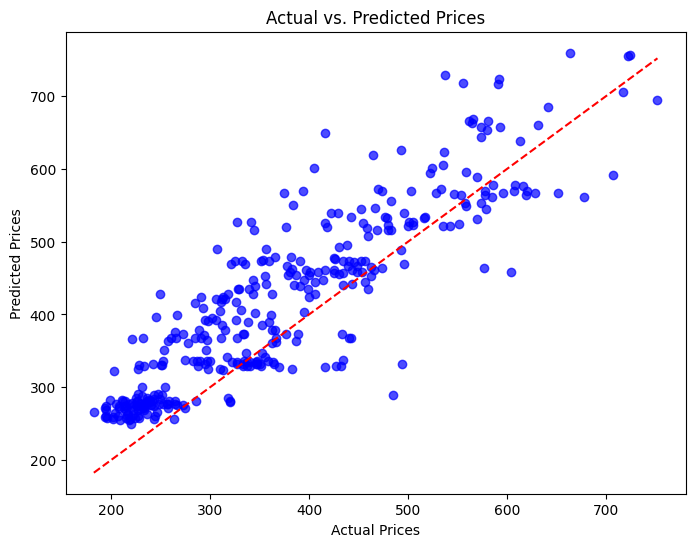

In [246]:
# Plot: Actual vs. Predicted Prices
plt.figure(figsize=(8, 6))
plt.scatter(y_vali, sgd_predictions, alpha=0.7, color="blue")
plt.plot([y_vali.min(), y_vali.max()], [y_vali.min(), y_vali.max()], 'k--', color="red")
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs. Predicted Prices")
plt.show()

/tmp/ipykernel_8122/2661313248.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=coefficients, palette="Blues_r")


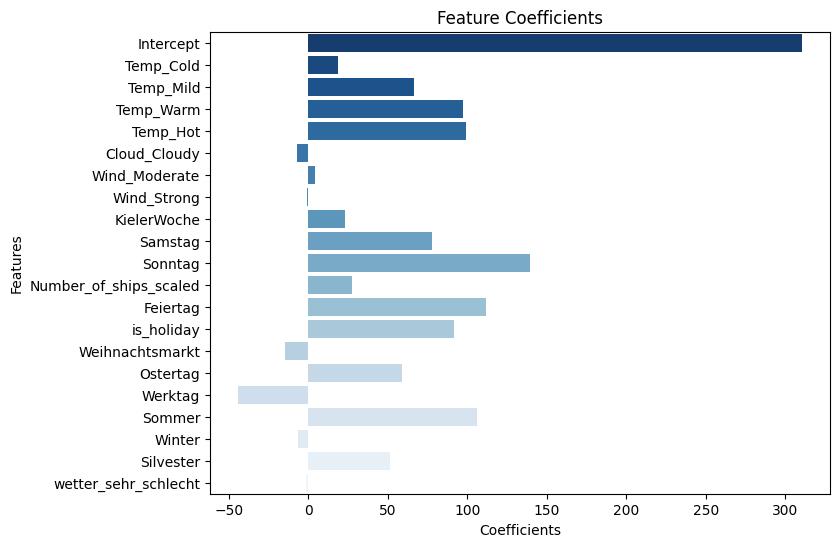

In [247]:
# Extract and display model coefficients
coefficients = pd.DataFrame({
    'Feature': ['Intercept'] + features,
    'Coefficient': [sgd_model.intercept_[0]] + list(sgd_model.coef_)
})
# Bar plot of feature coefficients
plt.figure(figsize=(8, 6))
sns.barplot(x='Coefficient', y='Feature', data=coefficients, palette="Blues_r")
plt.title("Feature Coefficients")
plt.xlabel("Coefficients")
plt.ylabel("Features")
plt.show()

***AB HIER VORHERSAGE FÜR TESTZEITRAUM***

In [248]:
df_test = pd.read_csv("/workspaces/bakery_sales_prediction/0_DataPreparation/00_data/Testdaten.csv")
#print(df_test.head())
data_test = df_test[df_test["Warengruppe_2"] == 1]
X_test = data_test[features]

# Check the dimensions of the datasets
print("Test dataset dimensions:", data_test.shape)

# Make predictions on the test set
sgd_predictions_test = sgd_model.predict(X_test)
print("Predictions for test data:", sgd_predictions_test[:5])  # Display first 5 predictions
# Größe des Arrays anzeigen
print("Größe des Arrays (shape):", sgd_predictions_test.shape)


KeyError: "['Number_of_ships_scaled', 'Werktag', 'Sommer', 'Winter', 'wetter_sehr_schlecht'] not in index"

In [18]:
# Erstelle Ziel csv Datei

# Extract the 'id' column
id_column = data_test["id"]
# Create a DataFrame with 'id' and 'Umsatz'
output_df = pd.DataFrame({"id": id_column,"Umsatz": sgd_predictions_test})
# Save to a CSV file
output_csv_path = "/workspaces/bakery_sales_prediction/2_BaselineModel/02_Franz/Umsatzvorhersage_Broetchen_Hochladeformat.csv"
output_df.to_csv(output_csv_path, index=False)
print(f"CSV Datei erstellt: {output_csv_path}")

CSV Datei erstellt: /workspaces/bakery_sales_prediction/2_BaselineModel/02_Franz/Umsatzvorhersage_Broetchen_Hochladeformat.csv
